In [1]:
import numpy as np
import pickle as pkl
import matplotlib.pyplot as plt
import torch
import glob

import bvcopula

%matplotlib inline
%load_ext autoreload
%autoreload 2

In [2]:
animal = 'ST263'
dayN = 4
day_name = 'Day{}'.format(dayN)
exp_pref = '{}_{}'.format(animal,day_name)
path = '/home/nina/models'

In [3]:
out_dir = '../models/'+exp_pref
with open(out_dir+'/summary.pkl','rb') as f:
    data = pkl.load(f)
n1=2
n2=20
data[n1+5,n2+5][0]

[FrankCopula_Likelihood(
   (quadrature): GaussHermiteQuadrature1D()
 ), IndependenceCopula_Likelihood(
   (quadrature): GaussHermiteQuadrature1D()
 ), GumbelCopula_Likelihood(
   (quadrature): GaussHermiteQuadrature1D()
 )]

In [4]:
import warnings
import sys
import traceback
from tqdm import tqdm
    
def warn_with_traceback(message, category, filename, lineno, file=None, line=None):
    log = file if hasattr(file,'write') else sys.stderr
    traceback.print_stack(file=log)
    log.write(warnings.formatwarning(message, category, filename, lineno, line))
    
def get_model(n1,n2,likelihoods,device):
    get_weights_filename = glob.glob('{}/{}/model_{}-{}.pth'.format(path,exp_pref,n1,n2))
    print(get_weights_filename)
    if len(get_weights_filename)>0:
        if len(get_weights_filename)>1:
            print('There is more then 1 file, taking the first one')
            return 0
        model = bvcopula.load_model(get_weights_filename[0], likelihoods, device)
        return model
    else:
        print('Weights file {} not found.'.format(get_weights_filename))
        return 0
        
def measure_MI(model,points,samp_mc_size=10000):
    MIs = []
    with torch.no_grad():
        fs = model(points).rsample(torch.Size([5])) #[samples_f, copulas, positions]
    f_mean = model(points).mean.unsqueeze(0)
    # now add mean f to a set of f samples
    fs = torch.cat((fs,f_mean),0) #[samples_f + 1, copulas, positions]
    fs = torch.einsum('ijk->jik', fs) #[copulas, samples_f + 1, positions] 
    
    f = fs.reshape((fs.shape[0],-1)) #[copulas, ( (samples_f + 1) x positions)]

    copula = model.likelihood(f)
    MI = copula.entropy()
    MIs = MI.reshape(fs.shape[1:]) #[(samples_f + 1), positions]
    MI_mean = MIs[-1]
    MIs = MIs[:-1]

    return (MI_mean,MIs.mean(dim=0),MIs.std(dim=0))

warnings.showwarning = warn_with_traceback

points = torch.linspace(0,1,20)
        
n1=-4
n2=6

print(data[n1+5,n2+5][1])

%time model = get_model(n1, n2, data[n1+5,n2+5][0], torch.device('cpu')) 
%time (ym, y, dy) = measure_MI(model, points)

IndependenceFrank
['/home/nina/models/ST263_Day4/model_-4-6.pth']
CPU times: user 244 ms, sys: 0 ns, total: 244 ms
Wall time: 10.7 ms
CPU times: user 2min 39s, sys: 4.83 s, total: 2min 44s
Wall time: 5.58 s


In [5]:
n1 = -4
for n2 in range(n1+1,20): 
    print(data[n1+5,n2+5][1],n1,n2)

Clayton0°Frank -4 -3
Frank -4 -2
Gaussian -4 -1
Independence -4 0
Independence -4 1
Independence -4 2
Independence -4 3
Gaussian -4 4
Frank -4 5
IndependenceFrank -4 6
Independence -4 7
Independence -4 8
Independence -4 9
Independence -4 10
Independence -4 11
Independence -4 12
Independence -4 13
Gaussian -4 14
Independence -4 15
Independence -4 16
Independence -4 17
Independence -4 18
Independence -4 19


In [6]:
with torch.no_grad():
    fs = model(points).rsample(torch.Size([5])) #[samples_f, copulas, positions]
f_mean = model(points).mean.unsqueeze(0)
# now add mean f to a set of f samples
fs = torch.cat((fs,f_mean),0) #[samples_f + 1, copulas, positions]
fs = torch.einsum('ijk->jik', fs) #[copulas, samples_f + 1, positions] 
f = fs.reshape((fs.shape[0],-1)) #[copulas, ( (samples_f + 1) x positions)]
copula = model.likelihood(f)
copula.theta.shape

torch.Size([2, 120])

In [7]:
torch.zeros(2).dim()

1

(-0.5, 0)

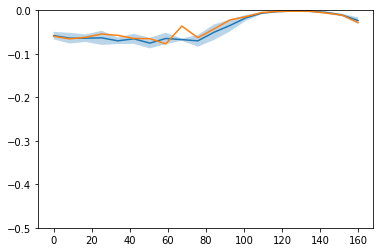

In [8]:
plt.plot(np.linspace(0,160,len(y)),y)
plt.fill_between(np.linspace(0,160,len(y)),y-dy,y+dy, alpha=0.3)
plt.plot(np.linspace(0,160,len(ym)),ym)
plt.ylim(-.5,0)

In [9]:
def input_information(model, n: int, scale: float, samp_mc_size=100, device=torch.device('cpu')):
        ds = scale/n #scale determines units of ds
        
        points = torch.linspace(0,1,n+3)

        with torch.no_grad():
            fs = model(points).rsample(torch.Size([20])) #[samples_f, copulas, positions]
        fs = torch.einsum('ijk->jki', fs) #[copulas, positions, samples_f] 
        f = fs.reshape((fs.shape[0],-1)) #[copulas, (samples_f x positions)]
            
        copula = model.likelihood._get_copula(f, sample_size = torch.Size([samp_mc_size]))
        samples = copula.rsample()
        logprob = copula.log_prob(samples)
        
        logprob = logprob.reshape((*fs.shape[1:],-1)) #[positions, samples_f]

        #calculate FI
        FI = torch.zeros_like(logprob[...,0])
        for i in range(1,n):
            FI[i] = ((logprob[i].exp())*((logprob[i+1]-logprob[i-1])/ds).pow(2)).sum(dim=-1)
            if (i>2) & (i<n-1):
                
#             #now calculate MI    
#             # P(r) = integral P(r|s) P(s) ds
#             Pr = torch.zeros(samples.shape[0]).cuda(device=get_cuda_device)
#             for i in range(n+1):
#                 Pr += logprob[i].exp().detach()*(1/(n+1))
#             MIs=0
#             for i in range(n+1):    
#                 MIs+= 1/(n+1)*logprob[i].exp()*(logprob[i]-Pr.log()) # sum p(r|s) * log p(r|s)/p(r)
#             MI = MIs.sum()     
        return (FI.mean(dim=-1),FI.std(dim=-1))

model = get_model(n1, n2, data[n1+5,n2+5][0], torch.device('cpu')) 
%time (FI, dFI) = input_information(model, 160, 160, device=torch.device('cpu'))

IndentationError: expected an indented block (<ipython-input-9-1edd0510d82b>, line 32)

In [ ]:
plt.plot(np.linspace(0,160,len(FI)),FI)
plt.fill_between(np.linspace(0,160,len(FI)),FI-dFI,FI+dFI, alpha=0.3)